In [34]:
# George Miloshevich 2022

import os, sys
import pickle
from pathlib import Path

from functools import partial # allows us to create a function with arguments passed

# North Atlantic Europe: France
#folder = Path('./xforanalogs/NA24by48/global_logit/yrs100/interT15')  # The name of the folder where the analogs have been stored
#folder = Path('./xforanalogs/ZGonlyNA24by48/Z16/yrs100/interT15fw20.1.20ZGskip2')
#folder_long = Path('./xforanalogs/NA24by48/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
#filename = './Images/NAE_France' # Where to store eventual image
# North Hemisphere: France
#folder = Path('./xforanalogs/NH24by128/global_logit/yrs100/interT15')
#folder_long = Path('./xforanalogs/NA24by48/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
#filename = './Images/NH_France' # Where to store eventual image

#folder = Path('./xforanalogs/5fold/T15/NAE/France/yrs100/Z0/global_logit')
#folder_long = Path('./xforanalogs/NA24by48/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
#filename = './Images/NH_France' # Where to store eventual image

# North Atlantic Europe: Scandinavia
#folder = Path('./xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15')   # The name of the folder where the analogs have been stored
#folder_long = Path('./xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
#filename = './Images/NAE_Scandinavia' # Where to store eventual image

folder = Path('./xforanalogs/5fold/T15/NAE/Scandinavia/yrs100/Z0/global_logit')   # The name of the folder where the analogs have been stored
folder_long = Path('./xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
filename = './Images/NAE_Scandinavia' # Where to store eventual image

# North Hemisphere
#folder = Path('./xforanalogs/ZGonlyNH24by128/Scandinavia/global_logit/yrs100/interT15')   # The name of the folder where the analogs have been stored
#folder_long = Path('./xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs8000/interT15') # The name of the folder where the full time series are stored
#filename = './Images/NH_Scandinavia' # Where to store eventual image

import logging
from colorama import Fore # support colored output in terminal
from colorama import Style
if __name__ == '__main__':
    logger = logging.getLogger()
    logger.handlers = [logging.StreamHandler(sys.stdout)]
else:
    logger = logging.getLogger(__name__)
logger.level = logging.INFO     

import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


#folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')
import pickle
import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print(ln)
print(ut)
print(tff)
import committor_analogue as ca
print(ca)
ca.tff = tff
ca.ut = ut
ca.ln = ln


import cartopy.crs as ccrs
import cartopy.feature as cfeat
import general_purpose.cartopy_plots as cplt

==Checking GPU==
==Checking CUDA==
<module 'PLASIM.Learn2_new' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Learn2_new.py'>
<module 'general_purpose.utilities' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/general_purpose/utilities.py'>
<module 'ERA.TF_Fields' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/TF_Fields.py'>
<module 'committor_analogue' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/VAE/committor_analogue.py'>


2023-02-10 13:19:57.252609: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Serial code

In [35]:
int_vector = np.vectorize(np.int_)

def TrajOnePoint(day, nn, n_Traj, numsteps, Markov_step, Matr_tr,n_days): # a day implies the temporal coordinates in days of the input from the 0-th year of the 1000 year long dataset
    """ Compute `n_Traj` trajectories starting from `day` that take `numsteps` steps
    Args:
        day (_int_):            day in the validation set where the Markov chain will start
        nn (_int_):             number of nearest neighbors to look for
        n_Traj (_int array_):         Number of MC samples that start from the same day (number of trajectories).
        numsteps (_int array_):       numbe of steps to take in each trajectory
        Markov_step (_int_):    step in the Markov chain (how many days)
        Matr_tr (_ndarray_):    T matrix inside the training set
        n_days (_int_):         number of days in a season
    """
    res = np.zeros((len(n_Traj),len(numsteps)))
    Matr_tr_trial = 0
    app_draw_index = -1 # This keeps track of how many times we drew random analogs at each Markov step (if there are not enough analogs we draw again)
    app_draw_index_traj = 0
    wrong_index = 0 # This checks that during input or execution we were always working with indecies that exist in the considered matrices and we don't go below or above
    if (day >= Matr_tr.shape[0]) or (day < 0): # We don't allow inputs that are outside of the range of Matr_va. 
        #print("day > Matr_va.shape[0]")
        wrong_index = 1 # manual debugging (unfortunately numba does not capture this)
        print("We don't allow inputs that are outside of the range of Matr_va")
        for l_1 in n_Traj:
            for l_2 in numsteps:
                res[l_1][l_2] = np.nan # we simply  don't have corresponding index
    else:
        #print("day <= Matr_va.shape[0]")
        app_draw_index_traj = 0
        for i in n_Traj:   
            s = day # We initialize trajectory at the first day
            res[i][0] = s
            #print("output: ", day,app,s, Matr_va.shape)
            if (s >= Matr_tr.shape[0]) or (s < 0):
                print("Index s = ",s, " is outside the range of Matr_tr")
                wrong_index = 1
            for j in numsteps[1:]: 
                #if (Matr_tr[s][nn] == Matr_tr.shape[0]):
                #    print("Trajectory", i, ", Iteration ", j, ". There are not enough analogs for this amount of neighbors (likely got removed when trimming moving average or self analogs)")
                Matr_tr_trial = Matr_tr.shape[0]
                app_draw_index = -1 # we set it to -1 because the first trial will increment by default even if it is successful
                while Matr_tr_trial == Matr_tr.shape[0]: # keep drawing until appropriate analogs are found
                    app = rd.randint(0,nn-1) #analogue selection
                    Matr_tr_trial =  Matr_tr[s][app]
                    app_draw_index += 1 
                if Matr_tr_trial == -1:
                    wrong_index = 1
                    print("Iteration ", j,"We have accidentally accessed -1 index which means there is a problem with Matr_tr")
                if Matr_tr_trial%n_days >= n_days-Markov_step:
                    wrong_index = 1
                    print("Iteration ", j,"We have accessed analog that has no next day, which could jump us across a year: Matr_tr[s][app] = ", Matr_tr_trial)
                    print("this happens for s =", s, " and app = ",app)
                if (Matr_tr_trial >= Matr_tr.shape[0]) or (Matr_tr[s][app] < 0):
                    print("Iteration ", j," ,Index s =", s, " and app =  ", app, " gives Matr_tr[s][app] = ", Matr_tr_trial)
                    print("is outside the range of Matr_tr which is ", Matr_tr.shape[0], " The day maps to  Matr_tr[s][app]%n_days = ",  Matr_tr_trial%n_days, " calendar day")
                    print("This is likely because there were not enough analogs after moving average was imposed. So we take random state")
                    wrong_index = 1
                s = Matr_tr[s][app] + Markov_step         #analog state s is evolved in time
                res[i][j] = s
                if (s >= Matr_tr.shape[0]) or (s < 0):
                    print("Index s after adding Markov_step = ",s, " is outside the range of Matr_tr which is ", Matr_tr.shape[0])
                    wrong_index = 1
                app_draw_index_traj += app_draw_index
        if app_draw_index_traj > 0:
            print("day", day, " had ", app_draw_index_traj , " unsuccessful analog draws")
        if wrong_index == 1:
            print("Somewhere inside the code there was an input outside of the range of matrices/vectors")
            for i in n_Traj:
                for j in numsteps:
                    res[l_1][l_2] = np.nan # we simply  don't have the corresponding index
        return int_vector(res)
        
def DressTrajOnePoint(day, ther,dela, Temp_va, Temp_tr, nn, n_Traj, numsteps, Markov_step, Matr_va, Matr_tr):
    """This function calls TrajOnePoint by selecting the right inputs provided to ca.CommOnePoint()
    """
    n_Traj = np.arange(n_Traj)
    numsteps = np.arange(numsteps) # Note that this overwrites what was prescribed in ca.RunNeighbors(). We want to simulate a day in summer
    res = []
    for day_i in day:
        res.append(TrajOnePoint(day_i, nn, n_Traj, numsteps, Markov_step, Matr_tr,dela)) # we use dela to convey number of days per season 
    return np.array(res)

## Numba powered code

In [36]:
import numba as nb
from numba import jit,guvectorize,set_num_threads
@guvectorize([(nb.int64,nb.int64,nb.int64[:],nb.int64[:],nb.int64,nb.int64[:,:],nb.int64[:,:])],
             '(),(),(n),(m),(),(k,o)->(n,m)',nopython=True,target="parallel") # to enable numba parallelism
def TrajOnePoint(day, nn, n_Traj, numsteps, Markov_step, Matr_tr,res): # a day implies the temporal coordinates in days of the input from the 0-th year of the 1000 year long dataset
    """ Compute `n_Traj` trajectories starting from `day` that take `numsteps` steps
    Args:
        day (_int_):            day in the validation set where the Markov chain will start
        nn (_int_):             number of nearest neighbors to look for
        n_Traj (_int array_):         Number of MC samples that start from the same day (number of trajectories).
        numsteps (_int array_):       numbe of steps to take in each trajectory
        Markov_step (_int_):    step in the Markov chain (how many days)
        Matr_tr (_ndarray_):    T matrix inside the training set
        res (_float_):          stores the committor (return), this is how numba vectorization forces the output to be treated
    """
    app_draw_index = -1 # This keeps track of how many times we drew random analogs at each Markov step (if there are not enough analogs we draw again)
    app_draw_index_traj = 0
    wrong_index = 0 # This checks that during input or execution we were always working with indecies that exist in the considered matrices and we don't go below or above
    if (day >= Matr_tr.shape[0]) or (day < 0): # We don't allow inputs that are outside of the range of Matr_va. 
        #print("day > Matr_va.shape[0]")
        wrong_index = 1 # manual debugging (unfortunately numba does not capture this)
        print("We don't allow inputs that are outside of the range of Matr_va")
        for l_1 in n_Traj:
            for l_2 in numsteps:
                res[l_1][l_2] = np.nan # we simply  don't have corresponding index
    if nn > Matr_tr.shape[1]:
        wrong_index = 1 # manual debugging: use to monitor if we get out of the Matr_tr allowed set
        print("We don't allow inputs that are outside of the range of Matr_va")
    else:
        app_draw_index_traj = 0 # initialize counter
        #print("day <= Matr_va.shape[0]")
        for i in n_Traj:   
            s = day # We initialize trajectory at the first day
            res[i][0] = s
            #print("output: ", day,app,s, Matr_va.shape)
            if (s >= Matr_tr.shape[0]) or (s < 0):
                wrong_index = 1
            for j in numsteps[1:]: 
                #if (Matr_tr[s][nn] == Matr_tr.shape[0]):
                #    print("Trajectory", i, ", Iteration ", j, ". There are not enough analogs for this amount of neighbors (likely got removed when trimming moving average or self analogs)")
                Matr_tr_trial = Matr_tr.shape[0]
                app_draw_index = -1 # we set it to -1 because the first trial will increment by default even if it is successful
                while Matr_tr_trial == Matr_tr.shape[0]: # keep drawing until appropriate analogs are found
                    app = rd.randint(0,nn-1) #analogue selection
                    Matr_tr_trial =  Matr_tr[s][app]
                    app_draw_index += 1 
                if Matr_tr_trial == -1:
                    wrong_index = 1
                    print("Iteration ", j,"We have accidentally accessed -1 index which means there is a problem with Matr_tr")
                if (Matr_tr_trial >= Matr_tr.shape[0]) or (Matr_tr[s][app] < 0):
                    print("Iteration ", j," ,Index s =", s, " and app =  ", app, " gives Matr_tr[s][app] = ", Matr_tr_trial)
                    wrong_index = 1
                s = Matr_tr[s][app] + Markov_step         #analog state s is evolved in time
                res[i][j] = s
                if (s >= Matr_tr.shape[0]) or (s < 0):
                    print("Index s after adding Markov_step = ",s, " is outside the range of Matr_tr which is ", Matr_tr.shape[0])
                    wrong_index = 1
                app_draw_index_traj += app_draw_index
        if app_draw_index_traj > 0:
            print("day", day, " had ", app_draw_index_traj , " unsuccessful analog draws")
        if wrong_index == 1:
            print("Somewhere inside the code there was an input outside of the range of matrices/vectors")
            for i in n_Traj:
                for j in numsteps:
                    res[l_1][l_2] = np.nan # we simply  don't have the corresponding index
        
def DressTrajOnePoint(day, ther,dela, Temp_va, Temp_tr, nn, n_Traj, numsteps, Markov_step, Matr_va, Matr_tr):
    """This function calls TrajOnePoint by selecting the right inputs provided to ca.CommOnePoint()
    """
    n_Traj = np.arange(n_Traj)
    numsteps = np.arange(numsteps) # Note that this overwrites what was prescribed in ca.RunNeighbors(). We want to simulate a day in summer
    return TrajOnePoint(day, nn, n_Traj, numsteps, Markov_step, Matr_tr)

## Prepare kwargs (parameters) of the run

In [37]:
ca.CommOnePoint = DressTrajOnePoint

ln.RunCheckpoints = ca.RunCheckpoints
ln.RunNeighbors = ca.RunNeighbors
ln.RunFolds = ca.RunFolds


#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')
year_permutation = np.load(f'{folder}/year_permutation.npy')
run_vae_kwargs = ut.json2dict(f"{folder}/config.json")

if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
threshold = np.array([np.load(f'{folder}/threshold.npy')]) #Threshold defining committor. This parameter I don't need, I shall perhaps transform it into epochs for variational autoencoder 
percent = ut.extract_nested(run_vae_kwargs, 'percent')
nfolds = ut.extract_nested(run_vae_kwargs, 'nfolds')

logger.info(f"{Style.RESET_ALL}")

extra_day=1
if ut.keys_exists(run_vae_kwargs, 'A_weights'):
    A_weights = ut.extract_nested(run_vae_kwargs, 'A_weights')
    if A_weights is not None:
        extra_day = A_weights[0] # We need to see if the labels were interpolated to see how much the algorithm should jump each summer
if extra_day == 3:
    delay = np.arange(6)
else:
    delay = 3*np.arange(6)

T = ut.extract_nested(run_vae_kwargs, 'T')//extra_day
n_days = time_end-time_start-T*extra_day+1   

RunFolds_kwargs_default = ln.get_default_params(ca.RunFolds, recursive=True)
RunFolds_kwargs_default = ut.set_values_recursive(
    RunFolds_kwargs_default, {'num_Traj' : 800, 'chain_step' : extra_day,  'threshold' : threshold, 'removeoutsidemovingwindow' : False,
                                'delay' : n_days, 'neighbors' : [3,5,10,20,40], 'num_steps' : (n_days - (label_period_start-time_start))//extra_day,
                              'T' : T, 'allowselfanalogs' : True, 'input_set' : 'va', 'bulk_set' : 'tr',
                              'start_calendar_day' :(label_period_start-time_start), 'start_day_set' : 'tr'}  )
area = ut.extract_nested(run_vae_kwargs, 'area')
chain_step = ut.extract_nested(RunFolds_kwargs_default, 'chain_step')  
logger.info(RunFolds_kwargs_default)




#logger.info(f'{sec[10][10].shape = }')

#logger.info(sec[10][10][0,0])

#logger.info(sec[10][10][0,0]%n_days)


{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': 15, 'start_day_set': 'tr', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 800, 'T': 5, 'chain_step': 3, 'neighbors': [3, 5, 10, 20, 40], 'delay': 105, 'num_steps': 30}}}


## Running the SWG

In [38]:
logger.info(f"{Fore.BLUE}") #  indicates we are inside the routine 
foldnum = 0
with open(f'{folder}/fold_{foldnum}/analogues.pkl', "rb") as open_file:
    analog = pickle.load(open_file)
analogues_tr = list(analog['ind_new_tr'].values())[foldnum] # Here we need to load just random analogs for the compilation below
time_series_tr = np.load(f"{folder}/fold_{0}/time_series_tr.npy")[:,0] #0th component contains temperature
#sec_1 = TrajOnePoint(33, [2,3,5,10,20,50],10, 5, chain_step, analogues_tr) # compiling (maybe we only need this once)
sec = ca.RunFolds(folder,1, threshold, n_days, **RunFolds_kwargs_default)[0]   # We only run 1 fold
logger.info(f"{Style.RESET_ALL}")
print(f'{sec[10][10].shape = }')
time_series_synth = {k: {j:time_series_tr[u] for j, u in v.items()} for k, v in sec.items()}
#logger.info(f'{time_series_synth[10][10].shape = }')
convolve_vec = np.vectorize(partial(np.convolve, **{'mode':'valid'}), signature='(n),(m)->(k)')

    
A_synth = {k: {j:convolve_vec(u,  np.ones(T)/T) for j, u in v.items()} for k, v in time_series_synth.items()}
logger.info(f'{sec[10][10].shape = }, {time_series_synth[10][10].shape = }, {A_synth[10][10].shape = }')
logger.info('Saving the synthetic time series in ')


RunFolds:
    fold = 0, loading from xforanalogs/5fold/T15/NAE/Scandinavia/yrs100/Z0/global_logit/fold_0/analogues.pkl
    RunCheckpoints:
        time_series_va.shape = (2100,), time_series_tr.shape = (8400,)
        checkpoint = 1.0
        Matr_tr.shape = (8400, 1000), Matr_va.shape = (2100, 1000), start_day_set = 'tr', start_calendar_day = 15
        days.shape = (80,)        
        RunNeighbors:
            num_Traj = 800, N_Steps = 30, chain_step = 3, T = 5, neighbors = [3, 5, 10, 20, 40], delay = 105, threshold = array([1.74679092])
            nn = 3
            nn = 5
            nn = 10
            nn = 20
            nn = 40
            q[nn].shape = (80, 800, 30)
        RunNeighbors: completed in 0.0 s
        checkpoint = 5.0
        Matr_tr.shape = (8400, 1000), Matr_va.shape = (2100, 1000), start_day_set = 'tr', start_calendar_day = 15
        days.shape = (80,)        
        RunNeighbors:
            num_Traj = 800, N_Steps = 30, chain_step = 3, T = 5, neighbors =

## Monitoring results

In [39]:
sec2days=sec[10][10]%n_days-time_start # Transforming the sequence of s to sequence of calendar days
sec2days.shape

(80, 800, 30)

np.max(np.diff(sec2days)) = 101, np.min(np.diff(sec2days)) = -101


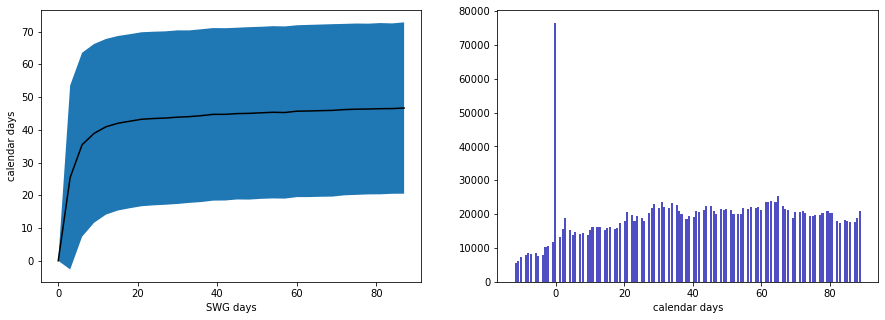

In [40]:
print(f'{np.max(np.diff(sec2days)) = }, {np.min(np.diff(sec2days)) = }')
import matplotlib.pyplot as plt
from pylab import rcParams
meansec2days = np.mean(sec2days.reshape(-1,sec2days.shape[2]),0)
stdsec2days = np.std(sec2days.reshape(-1,sec2days.shape[2]),0)
rcParams['figure.figsize'] = 15, 5
plt.subplot(121)
#plt.plot(sec2days.reshape(-1,sec2days.shape[2]).transpose()[:,:30])
plt.plot(extra_day*np.arange(len(meansec2days)),meansec2days,'k')
plt.fill_between(extra_day*np.arange(len(stdsec2days)),meansec2days-stdsec2days,meansec2days+stdsec2days)
plt.xlabel('SWG days')
plt.ylabel('calendar days')
plt.subplot(122)
n, bins, patches = plt.hist(sec2days.flatten(), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('calendar days')
#plt.plot((sec[10][10]%n_days-time_start).reshape(-1,n_days-time_start)[1,:])
#plt.plot((sec[10][10]%n_days-time_start).reshape(-1,n_days-time_start)[2,:])
plt.show()

## Preparing 100 years and 8000

In [41]:
time_series_tr_reshape = time_series_tr.reshape(-1,n_days)[:,(label_period_start-time_start):]
print(f'{time_series_tr_reshape.shape = }')
convseq = np.zeros(T*extra_day) # convolution to be used for running mean
convseq[range(0,T*extra_day,extra_day)] = 1/T
convseq = convseq[::-1]
print(f'{convseq = }')
A_tr = convolve_vec(time_series_tr_reshape,  convseq)
print(f'{np.mean([time_series_tr_reshape[33,33+3*i] for i in range(5)]) = }, {A_tr[33,33] = }')
time_series_tr_long = np.load(f'{folder_long}/fold_0/time_series_tr.npy')[:,0]
time_series_tr_reshape_long = time_series_tr_long.reshape(-1,n_days)[:,(label_period_start-time_start):]
print(f'{time_series_tr_reshape_long.shape = }')
convseq = np.zeros(T*extra_day) # convolution to be used for running mean
convseq[range(0,T*extra_day,extra_day)] = 1/T
convseq = convseq[::-1]
print(f'{convseq = }')
A_tr_long = convolve_vec(time_series_tr_reshape_long,  convseq)
print(f'{np.mean([time_series_tr_reshape_long[33,33+3*i] for i in range(5)]) = }, {A_tr_long[33,33] = }')

time_series_tr_reshape.shape = (80, 90)
convseq = array([0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. ,
       0. , 0.2])
np.mean([time_series_tr_reshape[33,33+3*i] for i in range(5)]) = -0.6964402, A_tr[33,33] = -0.6964402079582215
time_series_tr_reshape_long.shape = (7200, 90)
convseq = array([0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. ,
       0. , 0.2])
np.mean([time_series_tr_reshape_long[33,33+3*i] for i in range(5)]) = 1.3199497, A_tr_long[33,33] = 1.319949807226658


In [42]:
time_series_tr.shape, time_series_tr_reshape.shape, A_tr.shape

((8400,), (80, 90), (80, 76))

## Comparing statistics real vs synthetic

A.shape = (80, 76), label = 'Real100'
A.shape = (7200, 76), label = 'Real8000'
A.shape = (80, 800, 26), label = 1
A.shape = (80, 800, 26), label = 5
A.shape = (80, 800, 26), label = 500


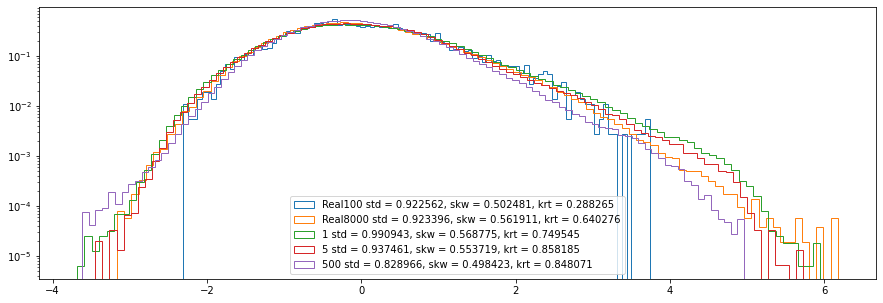

In [43]:
import scipy.stats as st
#coefs = (1,50,100) # alpha coefficients of interest
coefs = (1,5,500) # alpha coefficients of interest
nn = 10
for A, label in zip([A_tr,A_tr_long,*tuple([A_synth[coefsi][nn] for coefsi in coefs])],['Real100','Real8000', *coefs]):
    print(f'{A.shape = }, {label = }')
    flat_A = A.flatten()
    plt.hist(flat_A,bins=100,density=True,alpha=1, histtype='step', 
             label=f'{label} std = {np.std(flat_A):2f}, skw = {st.skew(flat_A):2f}, krt = {st.kurtosis(flat_A):2f}')
    plt.yscale('Log')
plt.legend(loc='lower center')
plt.savefig(f'{filename}_PDF.png')
plt.show()

In [44]:
time_series_tr.shape, time_series_synth[1][10].shape

((8400,), (80, 800, 30))

/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/ERA_Fields_New.py:741: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T = 2, Real100, xx_rt = [0.985483041788659, 3.923226388626335, 9.491221581029905, 39.49789020520718, 79.49895177091399, 79.49895177091399]
T = 2,Real100, yy_rt = [2.0264280438423157, 3.2587761878967285, 3.569000720977783, 4.525565266609192, 4.871165037155151, 4.871165037155151]
T = 2, Real8000, xx_rt = [1.0001011945072151, 3.9989569299821275, 10.002619141290367, 39.94735214501122, 99.49916247342207, 1028.0713475134585]
T = 2,Real8000, yy_rt = [1.9249609112739563, 3.0393022298812866, 3.6868739128112793, 4.504133701324463, 5.041193723678589, 6.205328702926636]
T = 2, Synthetic, xx_rt = [0.9999879277172413, 3.9999197124018853, 10.000699836776375, 40.0042460234085, 99.97012403283068, 999.4999166249727]
T = 2,Synthetic, yy_rt = [1.9333715438842773, 3.1066960096359253, 3.711796283721924, 4.702299118041992, 5.100990295410156, 5.9701361656188965]
T = 5, Real100, xx_rt = [0.985483041788659, 3.923226388626335, 9.491221581029905, 39.49789020520718, 79.49895177091399, 79.49895177091399]
T = 5,Real

<Figure size 1800x1800 with 0 Axes>

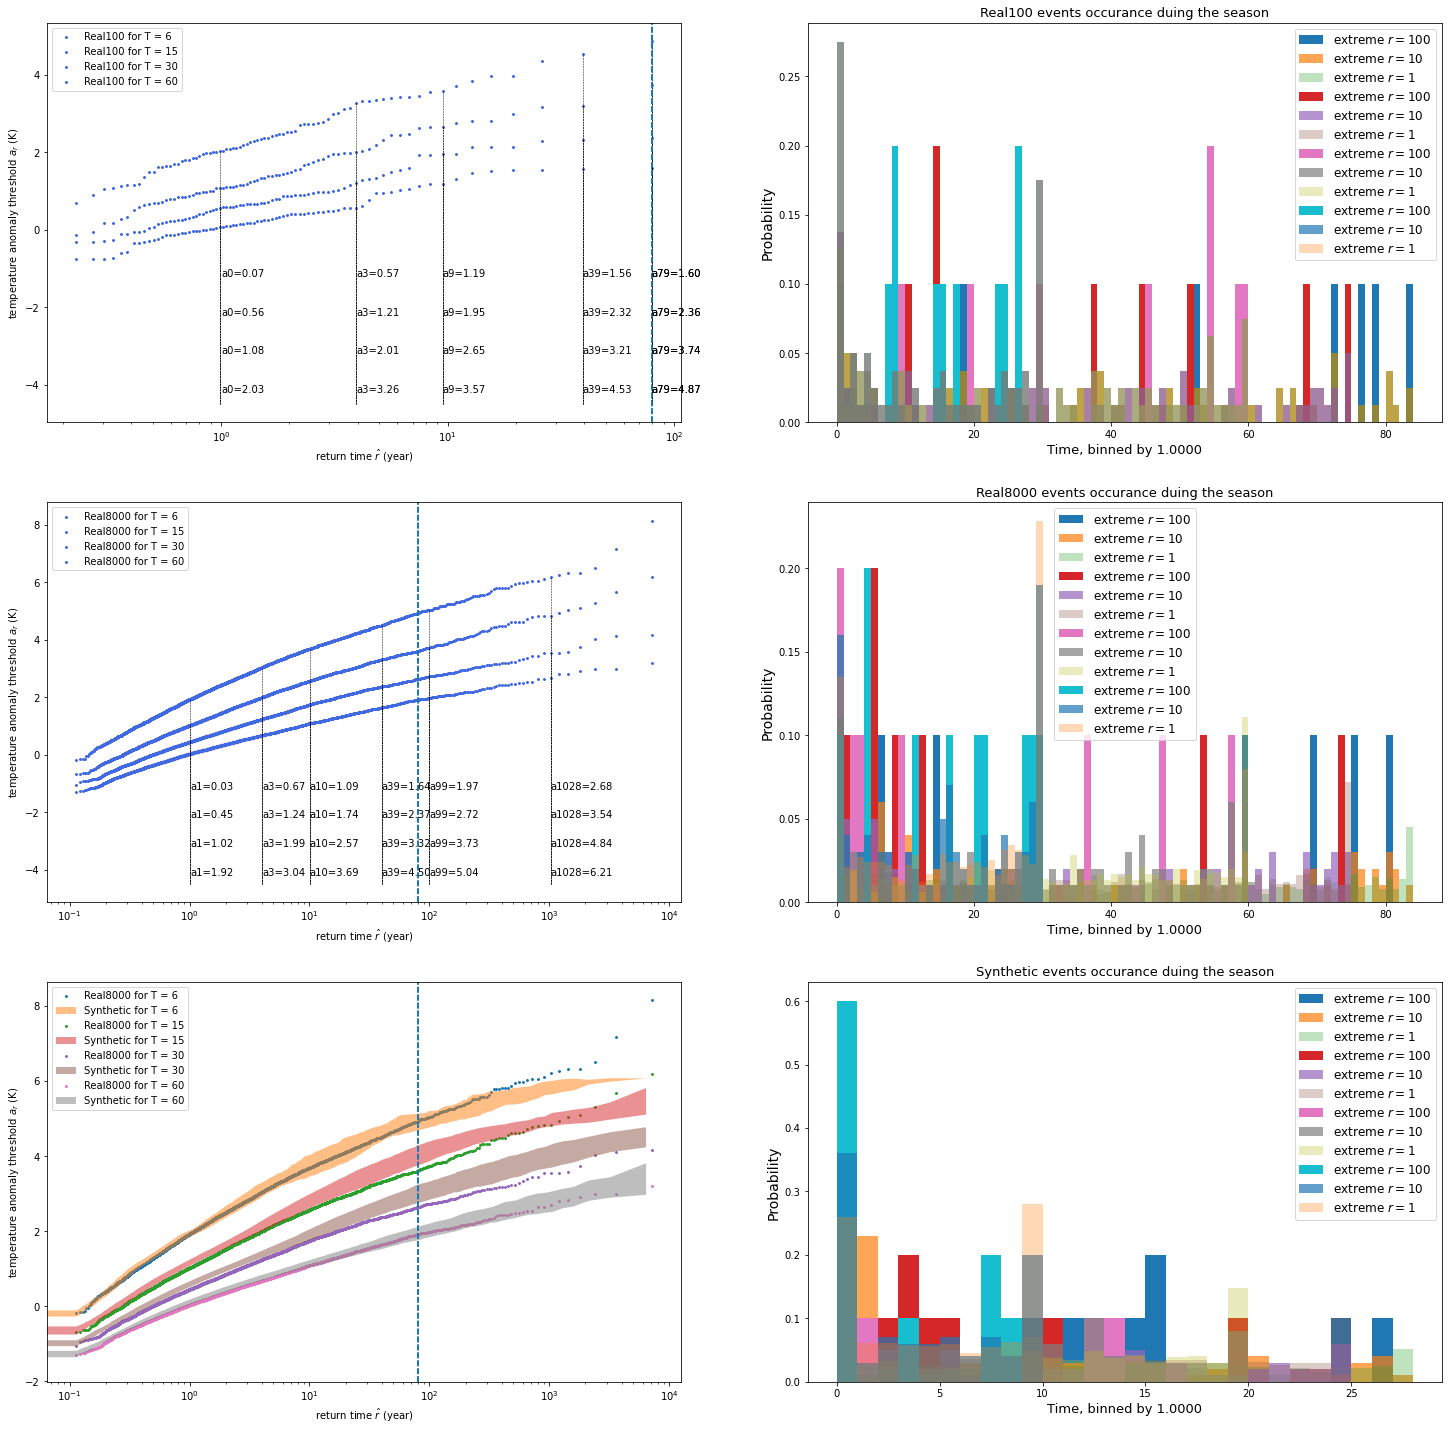

In [45]:

fig = plt.figure(figsize=(25, 25))
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(25,25))
A_max_sorted_dict = {}
for t, T in enumerate([2,5,10,20]):
    A_max_sorted_dict[T] = {}
    for j, (T_Summer, mylabel) in enumerate(zip([time_series_tr, time_series_tr_long, time_series_synth[1][10]],["Real100","Real8000","Synthetic"])):
        if mylabel == "Synthetic":
            A_Summer = convolve_vec(T_Summer,  np.ones(T)/T)
            A_Summer = A_Summer.reshape(-1,A_Summer.shape[2]) # collapse the dimensions 0 and 1, which correspond to 90 years of original data (starting in the same calendar day) and all the clones
        else:
            T_Summer_reshape = T_Summer.reshape(-1,n_days)[:,(label_period_start-time_start):]
            #print(f'{T_Summer_reshape.shape = }')
            convseq = np.zeros(T*extra_day) # convolution to be used for running mean
            convseq[range(0,T*extra_day,extra_day)] = 1/T
            convseq = convseq[::-1]
            #print(f'{convseq = }')
            A_Summer = convolve_vec(T_Summer_reshape,  convseq)
        #print(mylabel, f" {A_Summer.shape = }")
        #print(f'{j = }')
        ax1 = axs[j,0]
        #A_max, Ti, year_a = a_max_and_ti_postproc(A_Summer, A_Summer.shape[1])
        if mylabel == "Synthetic":
            ax1.scatter(XX_rt, YY_rt, s=4, marker='x',label=f"Real8000 for T = {T*extra_day}") 
            XX_rt_i, YY_rt_i = [], []
            #print(f'{A_Summer.shape[0] = }')
            for i in range(10):
                A_max_i = np.max(A_Summer[i*A_Summer.shape[0]//10:(i+1)*A_Summer.shape[0]//10],1)
                Ti_i = np.argmax(A_Summer[i*A_Summer.shape[0]//10:(i+1)*A_Summer.shape[0]//10],1)
                year_a_i = range(len(A_max_i))
                #print(f"{A_max_i.shape = },{Ti_i.shape = }, {len(year_a_i) = },{Ti_i.min() = }, {Ti_i.max() = }")
                A_max_sorted_i = ln.ef.a_decrese(A_max_i, Ti_i, year_a_i)
                
                XX_rt_item, YY_rt_item, _, _ = ln.ef.return_time_fix(A_max_sorted_i, modified='yes')
                #print(f'{len(XX_rt_item) = },{len(YY_rt_item) = }')
                XX_rt_i.append(XX_rt_item)
                YY_rt_i.append(YY_rt_item)
            XX_rt_i = np.array(XX_rt_i)
            YY_rt_i = np.array(YY_rt_i)
            mean_YY_rt_i = np.mean(YY_rt_i,0)
            std_YY_rt_i = np.std(YY_rt_i,0)
            ax1.fill_between(XX_rt_i[0],mean_YY_rt_i-std_YY_rt_i,mean_YY_rt_i+std_YY_rt_i,alpha=0.5,label=f'{mylabel} for T = {T*extra_day}')
        A_max = np.max(A_Summer,1)
        Ti = np.argmax(A_Summer,1)
        #print(f'{Ti = }')
        year_a = range(len(A_max))
        #print(f"{A_max.shape = },{Ti.shape = }, {len(year_a) = }")
        #print(f"{Ti.min() = }, {Ti.max() = }")
        A_max_sorted = ln.ef.a_decrese(A_max, Ti, year_a)
        A_max_sorted_dict[T][mylabel] = A_max_sorted
        XX_rt, YY_rt, xx_rt, yy_rt = ln.ef.return_time_fix(A_max_sorted, modified='yes')
        print(f"{T = }, {mylabel}, {xx_rt = }")
        print(f"{T = },{mylabel}, {yy_rt = }")
        
        
        if mylabel != "Synthetic":
            ax1.scatter(XX_rt, YY_rt, s=4, color='royalblue', marker='x',label=f'{mylabel} for T = {T*extra_day}')
            for i in range(len(xx_rt)):
                ax1.text(xx_rt[i] + 0.02, -4.2+t, f'a{int(xx_rt[i])}={yy_rt[i]:.2f}')
                ax1.plot([xx_rt[i], xx_rt[i]], [-4.5, yy_rt[i]], linestyle='--', color='black', linewidth=0.5)
 
 
        ax1.legend(loc="upper left")
        ax1.set_xscale('log')
        ax1.set_xlabel('return time $\hat{r}$ (year)')
        ax1.set_ylabel('temperature anomaly threshold $a_r$ (K)')
        ax1.axvline(analogues_tr.shape[0]//n_days,linestyle='--')
        #ax1.set_title(mylabel+' Temperature anomalies over '+ area, loc='left')
        Days = np.zeros(len(A_max_sorted))
        years = np.zeros(len(A_max_sorted))
        thresholds = np.zeros(len(A_max_sorted))
        for i, key in enumerate(A_max_sorted):
            thresholds[i] = key[0]
            years[i] = key[1][1]
            Days[i] = key[1][0]  
        
        Ax = axs[j,1]
        n, bins, patches = Ax.hist(Days[:10], bins = np.arange(0,A_Summer.shape[1]), density = True, alpha=1, label = 'extreme $r=100$')
        #print(f"{n = }")
        Ax.hist(Days[:100], bins = np.arange(0,A_Summer.shape[1]), density = True, alpha=0.7, label = 'extreme $r=10$')
        Ax.hist(Days[:1000], bins = np.arange(0,A_Summer.shape[1]), density = True, alpha=0.3, label = 'extreme $r=1$')
        Ax.set_xlabel('Time, binned by {:1.4f}'.format(bins[1]-bins[0]), fontsize=13)
        Ax.set_ylabel('Probability', fontsize=14)
        #Ax.set_ylim([0, 0.75*np.max(n)])
        Ax.set_title(mylabel+" events occurance duing the season", fontsize=13)
        Ax.legend(loc = 'best', fontsize=12)
plt.show()
for j, mylabel in zip(range(2),["Real","Synthetic"]):
    extent = ax1.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'{filename}_Returns.png', bbox_inches=extent )
T = 5

In [46]:
a,b,c,d = ln.ef.return_time_fix(A_max_sorted_dict[5]["Real8000"], modified='yes')
np.where(np.array(b)<5.414555454254151)[0][0]

2

In [47]:
a,b,c,d = ln.ef.return_time_fix(A_max_sorted_dict[5]["Synthetic"], modified='yes')
np.where(np.array(b)<5.414555454254151)[0][0]


8

In [48]:

if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'myinput' : 'N', 'evaluate_epoch' :1, 'time_start' : time_start}) #, 'time_end' : time_end}) # it doesn't matter which checkpoint we choose since we do not need the output of the VAE
else:
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'myinput' : 'N', 'evaluate_epoch' :1}) # backward compatibiity where there was no month of may
if not os.path.exists(ut.extract_nested(run_vae_kwargs, 'mylocal')): # we are assuming that training was not run on R740server5
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'mylocal' : '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'})
run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'range_nfolds' : [foldnum],'normalization_mode' : 'None', 'lon_start' : -64, 'lon_end' : 64})
logger.info(f"{Fore.BLUE}") #  indicates we are inside the routine  
history, N_EPOCHS, INITIAL_EPOCH, checkpoint_path, LAT, LON, vae, X_va, Y_va, X_tr, Y_tr, _ = foo.run_vae(folder, **run_vae_kwargs)
logger.info(f"{Style.RESET_ALL}")
X_tr_reshaped = X_tr.reshape(-1,n_days,*X_tr.shape[1:])[:,(label_period_start-time_start):,...]


run_vae:
    myinput = 'N'
     inputs lat_W = 24, lon_W = 128
    encoder_conv_filters1 = 32, encoder_conv_kernel_size1 = 3, encoder_conv_strides1 = 2, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 12.0, lon_W = 64.0
    encoder_conv_filters1 = 64, encoder_conv_kernel_size1 = 3, encoder_conv_strides1 = 2, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 6.0, lon_W = 32.0
    encoder_conv_filters1 = 64, encoder_conv_kernel_size1 = 3, encoder_conv_strides1 = 2, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 3.0, lon_W = 16.0
    encoder_conv_filters1 = 64, encoder_conv_kernel_size1 = 3, encoder_conv_strides1 = 1, encoder_conv_padding1 = 'valid'
     processing layer results in the dimension lat_W = 1.0, lon_W = 14.0
    decoder_conv_filters1 = 64, decoder_conv_kernel_size1 = 3, decoder_conv_strides1 = 1, decoder_conv_padding1 = 'valid'
     processing layer results in the

# Composite maps

Below we will compute different composite maps. First from the original 90 year training set. We will extract the most extreme heatwave and study it

In [49]:
for t, T in enumerate([5]):
    for j, (T_Summer, mylabel) in enumerate(zip([time_series_tr],["Real100"])):
        
        T_Summer_reshape = T_Summer.reshape(-1,n_days)[:,(label_period_start-time_start):]
        print(f'{T_Summer_reshape.shape = }')
        convseq = np.zeros(T*extra_day) # convolution to be used for running mean
        convseq[range(0,T*extra_day,extra_day)] = 1/T
        convseq = convseq[::-1]
        print(f'{convseq = }')
        A_Summer = convolve_vec(T_Summer_reshape,  convseq)
        print(mylabel, f" {A_Summer.shape = }")
        print(f'{j = }')
        #A_max, Ti, year_a = a_max_and_ti_postproc(A_Summer, A_Summer.shape[1])
        A_max = np.max(A_Summer,1)
        Ti = np.argmax(A_Summer,1)
        #print(f'{Ti = }')
        year_a = range(len(A_max))
        print(f"{A_max.shape = },{Ti.shape = }, {len(year_a) = }")
        print(f"{Ti.min() = }, {Ti.max() = }")
        A_max_sorted = ln.ef.a_decrese(A_max, Ti, year_a)

A_max_sorted[:10]

T_Summer_reshape.shape = (80, 90)
convseq = array([0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0. ,
       0. , 0.2])
Real100  A_Summer.shape = (80, 76)
j = 0
A_max.shape = (80,),Ti.shape = (80,), len(year_a) = 80
Ti.min() = 0, Ti.max() = 75


[(3.741802310943604, [44, 1]),
 (3.2053585052490234, [14, 42]),
 (3.1716115474700928, [74, 61]),
 (2.989518260955811, [68, 22]),
 (2.8149040699005132, [10, 40]),
 (2.8127890110015867, [37, 62]),
 (2.7509932041168215, [9, 21]),
 (2.645082247257233, [14, 0]),
 (2.641691303253174, [51, 60]),
 (2.6138361334800724, [26, 41])]

### The most extreme heatwave in 90 year long dataset at $\tau=0$

In [50]:
import importlib as imp
imp.reload(cplt)

<module 'general_purpose.cartopy_plots' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/general_purpose/cartopy_plots.py'>

extreme_X[0].shape = (24, 128, 1), A_max_sorted[:i_sorted] = [(3.741802310943604, [44, 1])]
norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fb127b8dd90>


/home/gmiloshe/miniconda3/envs/myenvnew/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'shrink'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/general_purpose/cartopy_plots.py:138: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


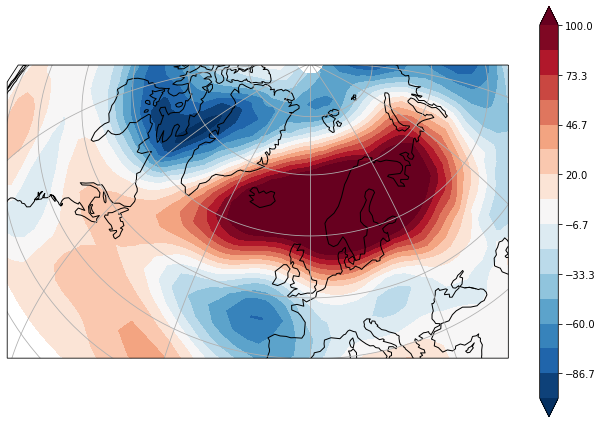

In [51]:
i_sorted = 1
extreme_X = [X_tr_reshaped[value[1][1],value[1][0],...,1:2] for value in A_max_sorted[:i_sorted]]
print(f'{extreme_X[0].shape = }, {A_max_sorted[:i_sorted] = }')
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(extreme_X,0),projections=[ccrs.Orthographic(0, 55)],
                         fig_num=8, put_colorbar=True, levs=np.linspace(-100,100,16), use_norm=False,
                         extents=(-100, 40, 30, 60), shrink=0.75, figure=fig,
                         mode='contourf',draw_labels=False,draw_gridlines=True
                        )
fig.savefig(f'Images/teleconnection_{area}100.png', bbox_inches="tight", dpi=200)


This is just (3-day interpolated) single day snapshot. So it is less informative. 

extreme_X[0][0].shape = (128, 1), A_max_sorted[:i_sorted] = [(3.741802310943604, [44, 1])]


/home/gmiloshe/miniconda3/envs/myenvnew/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'levs', 'use_norm', 'shrink', 'figure'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


<Figure size 648x432 with 0 Axes>

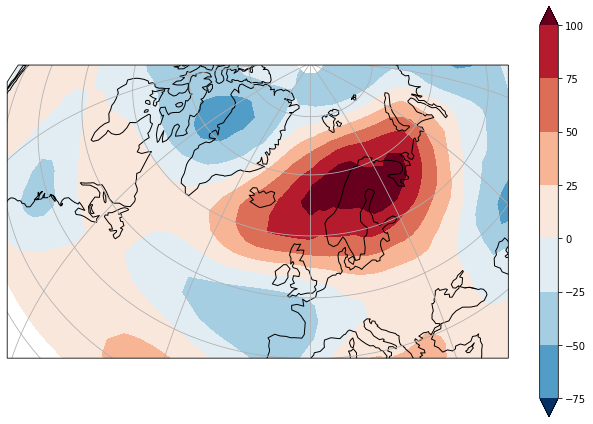

In [52]:
i_sorted = 1
extreme_X = [X_tr_reshaped[value[1][1],value[1][0]+next_day,...,1:2] for next_day in range(-9,9,3) for value in A_max_sorted[:i_sorted]]
print(f'{extreme_X[0][0].shape = }, {A_max_sorted[:i_sorted] = }')
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot(LON, LAT, np.mean(extreme_X,0),projections=[ccrs.Orthographic(0, 55)],
                         fig_num=8, put_colorbar=True, levs=np.linspace(-100,100,16), use_norm=False,
                         extents=(-100, 40, 30, 60), shrink=0.75, figure=fig,
                         mode='contourf',draw_labels=False,draw_gridlines=True
                        )
fig.savefig(f'Images/mean_teleconnection_{area}100.png', bbox_inches="tight", dpi=200)

## Compute extremes of synthetic series

In [53]:
for t, T in enumerate([5]):
    for j, (T_Summer, sec_Summer, mylabel) in enumerate(zip([time_series_synth[500][10]],[sec[500][10]],["Synthetic"])):
        
        A_Summer = convolve_vec(T_Summer,  np.ones(T)/T)
        A_Summer = A_Summer.reshape(-1,A_Summer.shape[2])
        sec_Summer_reshaped = sec_Summer.reshape(-1,sec_Summer.shape[2])
        print(mylabel, f" {A_Summer.shape = }")
        print(f'{j = }')
        #A_max, Ti, year_a = a_max_and_ti_postproc(A_Summer, A_Summer.shape[1])
        A_max = np.max(A_Summer,1)
        Ti = np.argmax(A_Summer,1)
        #print(f'{Ti = }')
        year_a = range(len(A_max))
        print(f"{A_max.shape = },{Ti.shape = }, {len(year_a) = }")
        print(f"{Ti.min() = }, {Ti.max() = }")
        A_max_sorted = ln.ef.a_decrese(A_max, Ti, year_a)
a,b,c,d = ln.ef.return_time_fix(A_max_sorted, modified='yes')
i_sorted = np.where(np.array(b)<3.5379160881042484)[0][0]
print(f'{i_sorted = }')

Synthetic  A_Summer.shape = (64000, 26)
j = 0
A_max.shape = (64000,),Ti.shape = (64000,), len(year_a) = 64000
Ti.min() = 0, Ti.max() = 25
i_sorted = 616


/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/ERA_Fields_New.py:741: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


extreme_X[0].shape = (24, 128, 1), A_max_sorted[i_sorted] = (3.537323999404908, [10, 54910])
norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fb0d66cca90>


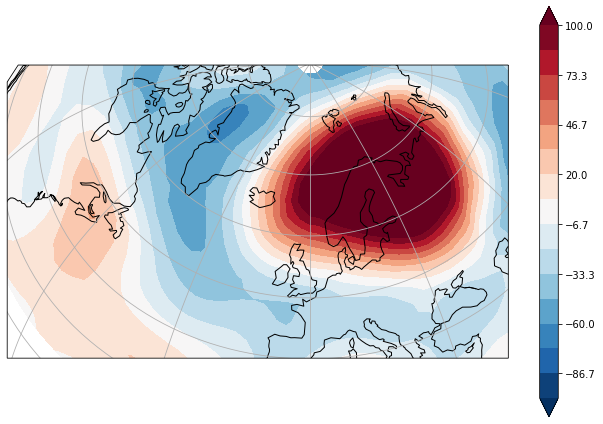

In [54]:


extreme_X = [X_tr[sec_Summer_reshaped[value[1][1],value[1][0]],...,1:2] for value in A_max_sorted[:i_sorted]]
print(f'{extreme_X[0].shape = }, {A_max_sorted[i_sorted] = }')

fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(extreme_X,0),projections=[ccrs.Orthographic(0, 55)],
                         fig_num=8, put_colorbar=True, levs=np.linspace(-100,100,16), use_norm=False,
                         extents=(-100, 40, 30, 60), shrink=0.75, figure=fig,
                         mode='contourf',draw_labels=False,draw_gridlines=True
                        )
fig.savefig(f'Images/teleconnection_{area}_synthetic.png', bbox_inches="tight", dpi=200)


extreme_X[0].shape = (24, 128, 1), A_max_sorted[i_sorted] = (4.497354602813721, [15, 43345])
norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fb0d4f10190>


<GeoAxesSubplot:>

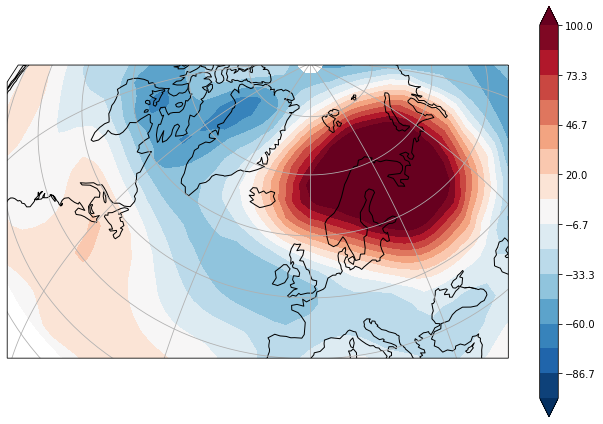

In [55]:
i_sorted = 30

extreme_X = [X_tr[sec_Summer_reshaped[value[1][1],value[1][0]+next_day],...,1:2] for next_day in range(-3,3,1) for value in A_max_sorted[:i_sorted]]
print(f'{extreme_X[0].shape = }, {A_max_sorted[i_sorted] = }')

cplt.multiple_field_plot2(LON, LAT, np.mean(extreme_X,0),projections=[ccrs.Orthographic(0, 55)],
                         fig_num=8, put_colorbar=True, levs=np.linspace(-100,100,16), use_norm=False,
                         extents=(-100, 40, 30, 60), shrink=0.75,
                         mode='contourf',draw_labels=False,draw_gridlines=True
                        )
